In [18]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from typing import Dict, Set, Tuple, List, Iterable, Optional, Hashable
from scipy.stats import spearmanr

Edge = Tuple[Hashable, Hashable]

In [9]:
def _edge_set_undirected(G: nx.Graph) -> Set[Tuple[Hashable, Hashable]]:
    out = set()
    for u, v in G.edges():
        if u == v:
            continue
        try:
            a, b = (u, v) if u < v else (v, u)
        except TypeError:
            a, b = (u, v) if str(u) < str(v) else (v, u)
        out.add((a, b))
    return out

In [19]:
def _edge_weight_dict(G: nx.Graph) -> dict[Edge, float]:
    """Ritorna un dizionario (edge -> peso), con edge come (min,max)."""
    weights = {}
    for u, v, data in G.edges(data=True):
        if u == v:
            continue
        a, b = (u, v) if u < v else (v, u)
        weights[(a, b)] = data.get("weight", 1.0)
    return weights

In [12]:
import numpy as np

def compute_z_value(null_model_ratios, original_ratio):
    """
    Computes the z-value for the original edge overlap ratio compared to null models.
    
    Parameters:
    - null_model_ratios (array-like): Array of edge overlap ratios from null models.
    - original_ratio (float): Edge overlap ratio from the original dataset.
    
    Returns:
    - z_value (float): The z-value of the original ratio.
    """
    # Calculate the mean and standard deviation of the null models
    mean_null = np.mean(null_model_ratios)
    std_null = np.std(null_model_ratios, ddof=1)  # Use ddof=1 for sample standard deviation
    
    # Compute the z-value
    z_value = (original_ratio - mean_null) / (std_null)
    
    return z_value


In [16]:
def compute_corr(E1,E2, weights1, weights2):
    common_edges = E1 & E2
    if len(common_edges) > 1:
        w1 = [weights1[e] for e in common_edges]
        w2 = [weights2[e] for e in common_edges]
        corr, _ = spearmanr(w1, w2)
        correlation = corr if not np.isnan(corr) else 0.0
    else:
        correlation = 0.0
    return correlation

In [ ]:
LAYER1_GEXF = "/Users/HP/Desktop/layer1.gexf"
LAYER2_GEXF = "/Users/HP/Desktop/layer2.gexf"
LAYER3_GEXF = "/Users/HP/Desktop/layer3.gexf"


# L1->L3

In [3]:
print(f"Loading Layer 1 from: {LAYER1_GEXF}")
layer1 = nx.read_gexf(LAYER1_GEXF)
print(f"Loaded Layer 1: |V|={layer1.number_of_nodes()}, |E|={layer1.number_of_edges()}")

Loading Layer 1 from: /Users/HP/Desktop/layer1.gexf
Loaded Layer 1: |V|=2599, |E|=55052


In [7]:
print(f"Loading Layer 3 from: {LAYER3_GEXF}")
layer3 = nx.read_gexf(LAYER3_GEXF)
print(f"Loaded Layer 3: |V|={layer3.number_of_nodes()}, |E|={layer3.number_of_edges()}")

Loading Layer 3 from: /Users/HP/Desktop/layer3.gexf
Loaded Layer 3: |V|=799, |E|=1936


## Preserving degree

In [ ]:
RESULTS = '/Users/HP/Desktop/UNI/LM_1/ACN/ACN_project/data/edge_overlap_L1_Null3.npy'
RESULTS_CORR = '/Users/HP/Desktop/UNI/LM_1/ACN/ACN_project/data/spearman_corr_L1_Null3.npy'

### Edge-overlap ratio

In [ ]:
edge_overlap_ratios = np.load(RESULTS)
print(f"Loaded edge overlap ratios from {RESULTS}, shape: {edge_overlap_ratios.shape}")

Loaded edge overlap ratios from /Users/HP/Desktop/UNI/LM_1/ACN/ACN_project/data/edge_overlap_L1_Null3.npy, shape: (5000,)


In [ ]:
E1 = _edge_set_undirected(layer1)
E3 = _edge_set_undirected(layer3)
expected_edge_overlap_ratio = len(E1 & E3) / min(len(E1), len(E3)) if min(len(E1), len(E3)) > 0 else 0.0

Expected edge overlap ratio: 0.1952479338842975
Mean edge overlap ratio: 0.08376043388429753
Standard deviation edge overlap ratio: 0.005063188630993482


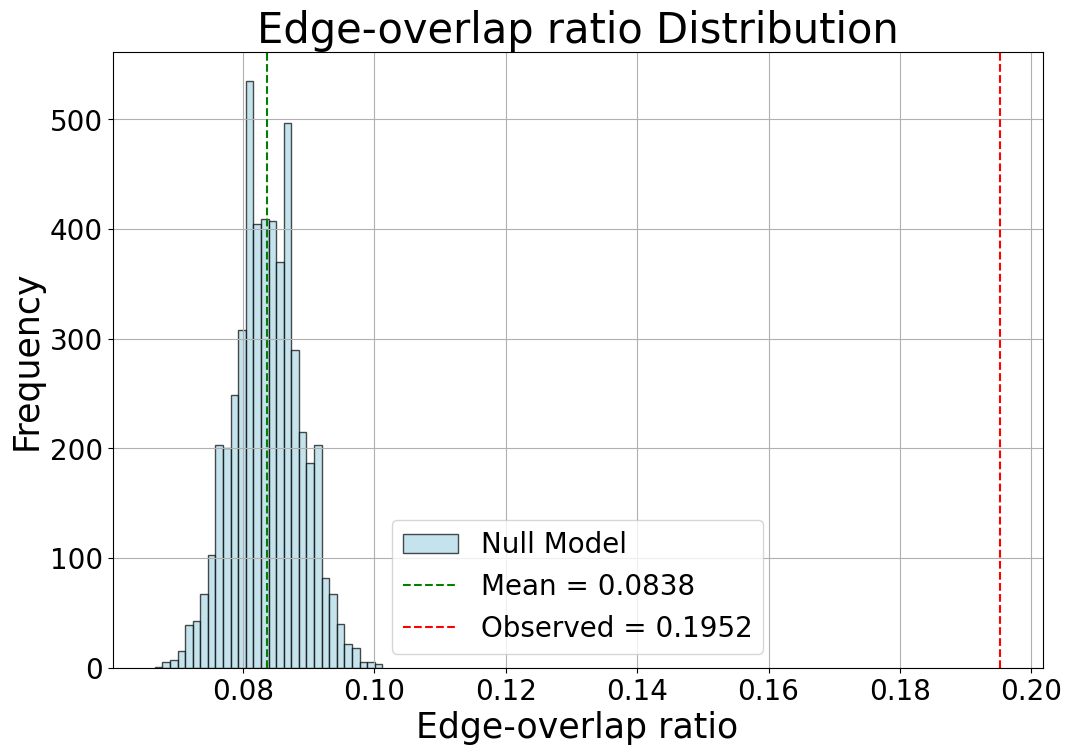

In [ ]:
plt.figure(figsize=(12, 8))
plt.hist(edge_overlap_ratios, bins=30, alpha=0.7, label="Null Model", color='lightblue', edgecolor='black')

print(f'Expected edge overlap ratio: {expected_edge_overlap_ratio}')
print(f'Mean edge overlap ratio: {np.mean(edge_overlap_ratios)}')
print(f'Standard deviation edge overlap ratio: {np.std(edge_overlap_ratios)}')
plt.xlabel('Edge-overlap ratio', size=25)
plt.ylabel('Frequency', size=25)
plt.title('Edge-overlap ratio Distribution', size=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.axvline(np.mean(edge_overlap_ratios), color='green', linestyle='--', label=f"Mean = {np.mean(edge_overlap_ratios):.4f}")
plt.axvline(expected_edge_overlap_ratio, color='red', linestyle='--', label=f"Observed = {expected_edge_overlap_ratio:.4f}")
plt.legend(fontsize=20)
plt.show()

In [ ]:
from scipy import stats
z_value = compute_z_value(edge_overlap_ratios, expected_edge_overlap_ratio)
print(f'z-value: {z_value}')

p_one_right = 1 - stats.norm.cdf(z_value)      # una coda destra
print(f'one-tailed right p-value: {p_one_right}')

z-value: 22.01702500478107


### Spearman correlation

In [ ]:
corr = np.load(RESULTS_CORR)
print(f"Loaded correlations from {RESULTS_CORR}, shape: {corr.shape}")

Loaded correlations from /Users/HP/Desktop/UNI/LM_1/ACN/ACN_project/data/spearman_corr_L1_Null3.npy, shape: (5000,)


In [ ]:
w1, w3 = _edge_weight_dict(layer1), _edge_weight_dict(layer3)
expected_corr = compute_corr(E1, E3, w1, w3)

Expected spearman correlation: 0.1328550436470079
Mean spearman correlation: -6.532632990060663e-05
Standard deviation spearman correlation: 0.08068558860937668


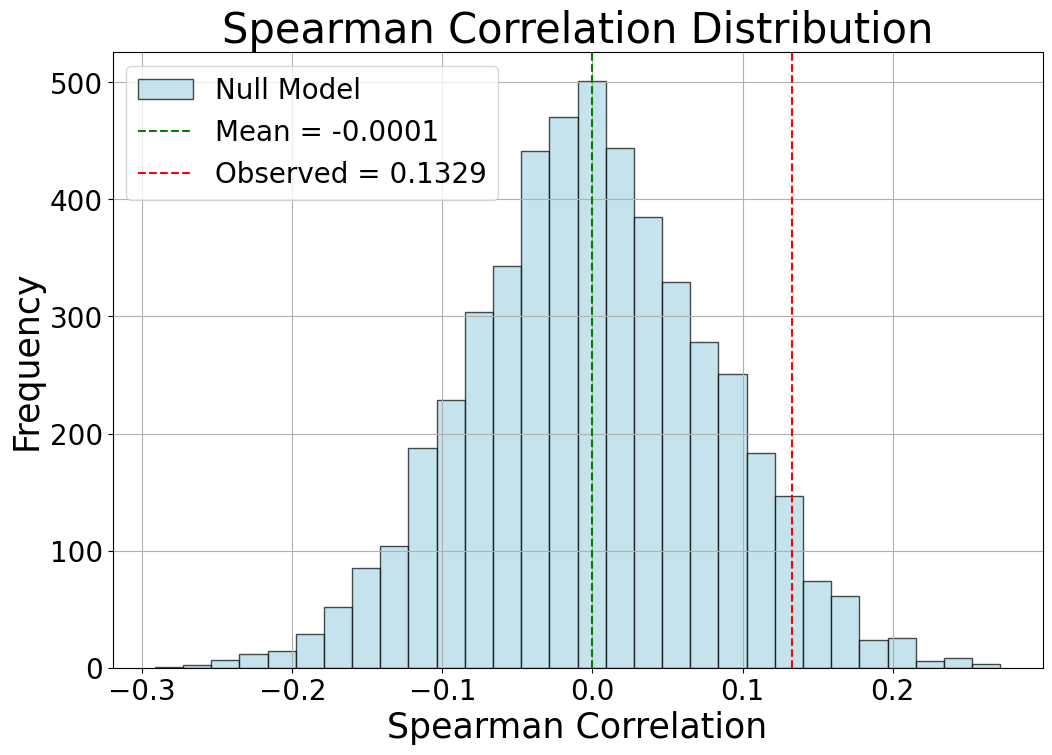

In [ ]:
plt.figure(figsize=(12, 8))
plt.hist(corr, bins=30, alpha=0.7, label="Null Model", color='lightblue', edgecolor='black')

print(f'Expected spearman correlation: {expected_corr}')
print(f'Mean spearman correlation: {np.mean(corr)}')
print(f'Standard deviation spearman correlation: {np.std(corr)}')
plt.xlabel('Spearman Correlation', size=25)
plt.ylabel('Frequency', size=25)
plt.title('Spearman Correlation Distribution', size=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.axvline(np.mean(corr), color='green', linestyle='--', label=f"Mean = {np.mean(corr):.4f}")
plt.axvline(expected_corr, color='red', linestyle='--', label=f"Observed = {expected_corr:.4f}")
plt.legend(fontsize=20)
plt.show()

In [ ]:
from scipy import stats
z_value = compute_z_value(corr, expected_corr)
print(f'z-value: {z_value}')

p_one_right = 1 - stats.norm.cdf(z_value)      # una coda destra
print(f'one-tailed right p-value: {p_one_right}')

z-value: 1.6472220078691604
one-tailed right p-value: 0.04975621091110294


## Preserving degree and weight sum

In [26]:
RESULTS = '/Users/HP/Desktop/UNI/LM_1/ACN/ACN_project/data/edge_overlap_L1_Null3_weights.npy'
RESULTS_CORR = '/Users/HP/Desktop/UNI/LM_1/ACN/ACN_project/data/spearman_corr_L1_Null3_weights.npy'

### Edge-overlap ratio

In [27]:
edge_overlap_ratios = np.load(RESULTS)
print(f"Loaded edge overlap ratios from {RESULTS}, shape: {edge_overlap_ratios.shape}")

Loaded edge overlap ratios from /Users/HP/Desktop/UNI/LM_1/ACN/ACN_project/data/edge_overlap_L1_Null3_weights.npy, shape: (5000,)


In [28]:
E1 = _edge_set_undirected(layer1)
E3 = _edge_set_undirected(layer3)
expected_edge_overlap_ratio = len(E1 & E3) / min(len(E1), len(E3)) if min(len(E1), len(E3)) > 0 else 0.0

Expected edge overlap ratio: 0.1952479338842975
Mean edge overlap ratio: 0.08373729338842975
Standard deviation edge overlap ratio: 0.004987050874893775


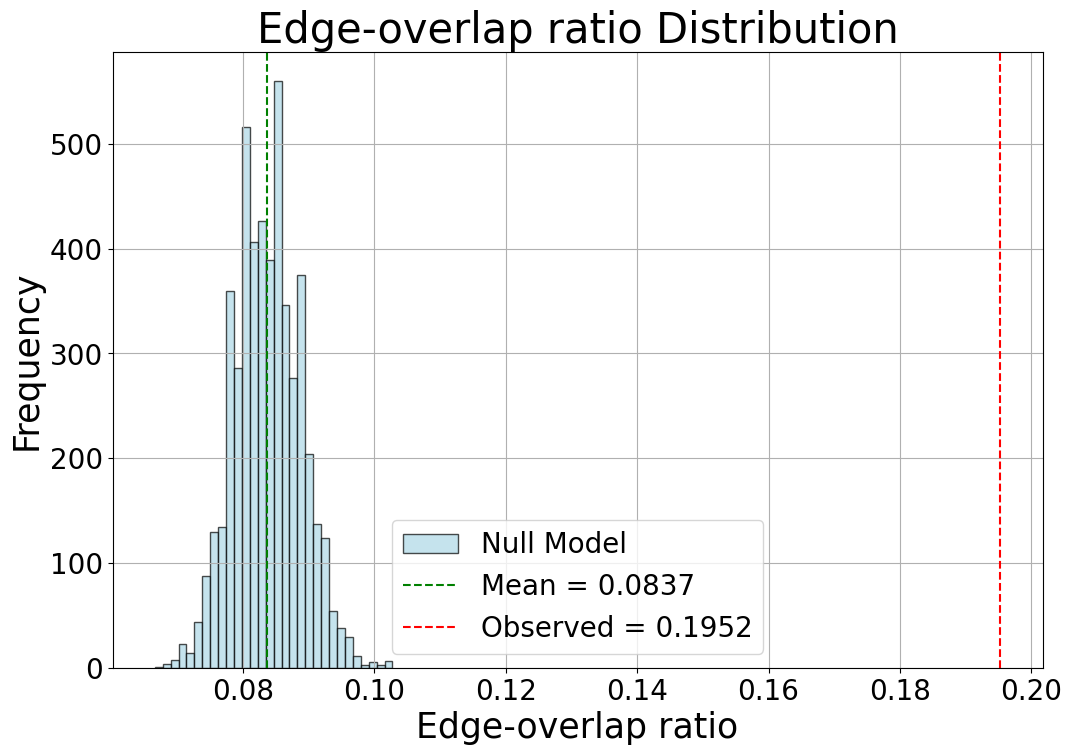

In [29]:
plt.figure(figsize=(12, 8))
plt.hist(edge_overlap_ratios, bins=30, alpha=0.7, label="Null Model", color='lightblue', edgecolor='black')

print(f'Expected edge overlap ratio: {expected_edge_overlap_ratio}')
print(f'Mean edge overlap ratio: {np.mean(edge_overlap_ratios)}')
print(f'Standard deviation edge overlap ratio: {np.std(edge_overlap_ratios)}')
plt.xlabel('Edge-overlap ratio', size=25)
plt.ylabel('Frequency', size=25)
plt.title('Edge-overlap ratio Distribution', size=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.axvline(np.mean(edge_overlap_ratios), color='green', linestyle='--', label=f"Mean = {np.mean(edge_overlap_ratios):.4f}")
plt.axvline(expected_edge_overlap_ratio, color='red', linestyle='--', label=f"Observed = {expected_edge_overlap_ratio:.4f}")
plt.legend(fontsize=20)
plt.show()

In [30]:
from scipy import stats
z_value = compute_z_value(edge_overlap_ratios, expected_edge_overlap_ratio)
print(f'z-value: {z_value}')

p_one_right = 1 - stats.norm.cdf(z_value)      # una coda destra
print(f'one-tailed right p-value: {p_one_right}')

z-value: 22.35780056616811
one-tailed right p-value: 0.0


### Spearman correlation

In [31]:
corr = np.load(RESULTS_CORR)
print(f"Loaded correlations from {RESULTS_CORR}, shape: {corr.shape}")

Loaded correlations from /Users/HP/Desktop/UNI/LM_1/ACN/ACN_project/data/spearman_corr_L1_Null3_weights.npy, shape: (5000,)


In [32]:
w1, w3 = _edge_weight_dict(layer1), _edge_weight_dict(layer3)
expected_corr = compute_corr(E1, E3, w1, w3)

Expected spearman correlation: 0.1328550436470079
Mean spearman correlation: -0.0511698591383184
Standard deviation spearman correlation: 0.08049728671980813


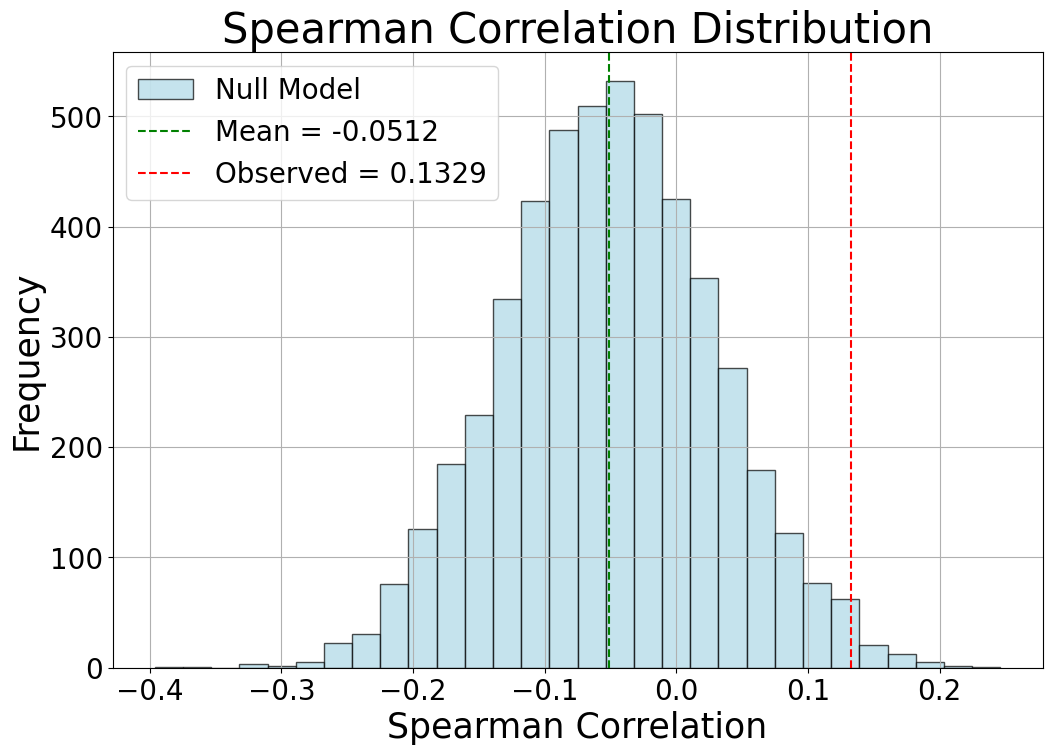

In [33]:
plt.figure(figsize=(12, 8))
plt.hist(corr, bins=30, alpha=0.7, label="Null Model", color='lightblue', edgecolor='black')

print(f'Expected spearman correlation: {expected_corr}')
print(f'Mean spearman correlation: {np.mean(corr)}')
print(f'Standard deviation spearman correlation: {np.std(corr)}')
plt.xlabel('Spearman Correlation', size=25)
plt.ylabel('Frequency', size=25)
plt.title('Spearman Correlation Distribution', size=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.axvline(np.mean(corr), color='green', linestyle='--', label=f"Mean = {np.mean(corr):.4f}")
plt.axvline(expected_corr, color='red', linestyle='--', label=f"Observed = {expected_corr:.4f}")
plt.legend(fontsize=20)
plt.show()

In [34]:
from scipy import stats
z_value = compute_z_value(corr, expected_corr)
print(f'z-value: {z_value}')

p_one_right = 1 - stats.norm.cdf(z_value)      # una coda destra
print(f'one-tailed right p-value: {p_one_right}')

z-value: 2.2858720693942636
one-tailed right p-value: 0.01113087194362894


## Preserving degree and clustering coefficient

In [ ]:
RESULTS = '/Users/HP/Desktop/UNI/LM_1/ACN/ACN_project/data/edge_overlap_L1_Null3_clustering.npy'
#RESULTS_CORR = '/Users/HP/Desktop/UNI/LM_1/ACN/ACN_project/data/spearman_corr_L1_Null3_clustering.npy'

### Edge-overlap ratio

In [41]:
edge_overlap_ratios = np.load(RESULTS)
print(f"Loaded edge overlap ratios from {RESULTS}, shape: {edge_overlap_ratios.shape}")

Loaded edge overlap ratios from /Users/HP/Desktop/UNI/LM_1/ACN/ACN_project/data/edge_overlap_L1_Null3_clustering.npy, shape: (5000,)


In [42]:
E1 = _edge_set_undirected(layer1)
E3 = _edge_set_undirected(layer3)
expected_edge_overlap_ratio = len(E1 & E3) / min(len(E1), len(E3)) if min(len(E1), len(E3)) > 0 else 0.0

Expected edge overlap ratio: 0.1952479338842975
Mean edge overlap ratio: 0.10565506198347109
Standard deviation edge overlap ratio: 0.0051255307853748195


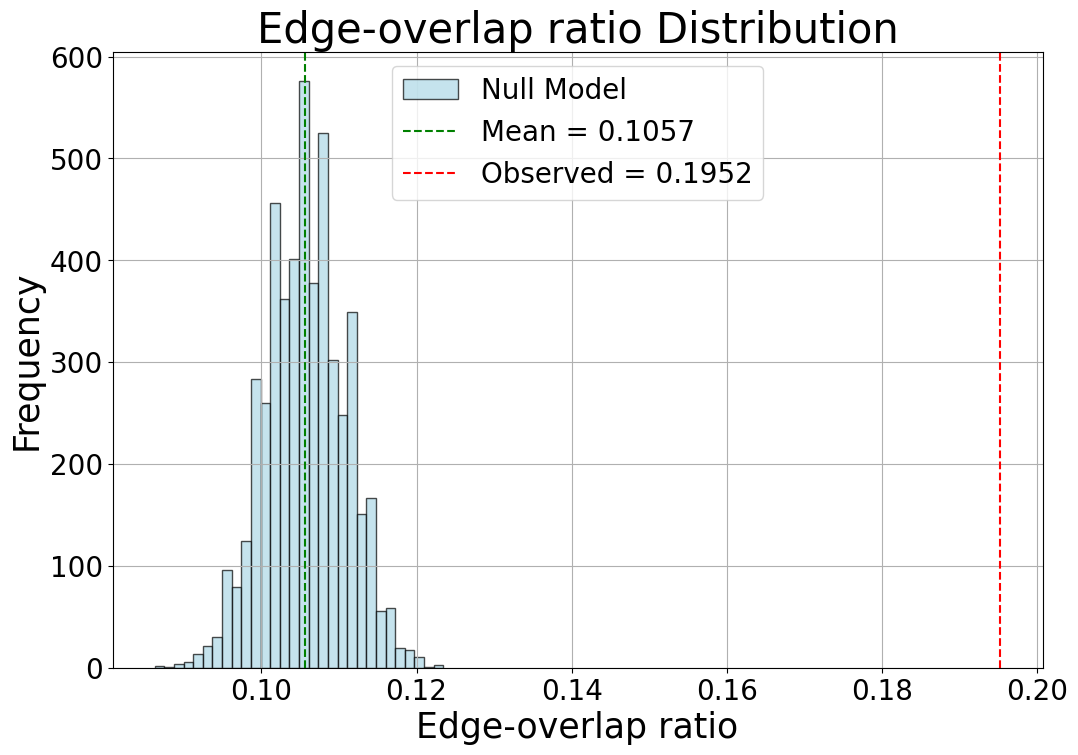

In [43]:
plt.figure(figsize=(12, 8))
plt.hist(edge_overlap_ratios, bins=30, alpha=0.7, label="Null Model", color='lightblue', edgecolor='black')

print(f'Expected edge overlap ratio: {expected_edge_overlap_ratio}')
print(f'Mean edge overlap ratio: {np.mean(edge_overlap_ratios)}')
print(f'Standard deviation edge overlap ratio: {np.std(edge_overlap_ratios)}')
plt.xlabel('Edge-overlap ratio', size=25)
plt.ylabel('Frequency', size=25)
plt.title('Edge-overlap ratio Distribution', size=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.axvline(np.mean(edge_overlap_ratios), color='green', linestyle='--', label=f"Mean = {np.mean(edge_overlap_ratios):.4f}")
plt.axvline(expected_edge_overlap_ratio, color='red', linestyle='--', label=f"Observed = {expected_edge_overlap_ratio:.4f}")
plt.legend(fontsize=20)
plt.show()

In [44]:
from scipy import stats
z_value = compute_z_value(edge_overlap_ratios, expected_edge_overlap_ratio)
print(f'z-value: {z_value}')

p_one_right = 1 - stats.norm.cdf(z_value)      # una coda destra
print(f'one-tailed right p-value: {p_one_right}')

z-value: 17.477977582584373
one-tailed right p-value: 0.0


### Spearman correlation

In [40]:
corr = np.load(RESULTS_CORR)
print(f"Loaded correlations from {RESULTS_CORR}, shape: {corr.shape}")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/HP/Desktop/UNI/LM_1/ACN/ACN_project/data/spearman_corr_L1_Null3_clustering.npy'

In [ ]:
w1, w3 = _edge_weight_dict(layer1), _edge_weight_dict(layer3)
expected_corr = compute_corr(E1, E3, w1, w3)

Expected spearman correlation: 0.1328550436470079
Mean spearman correlation: -0.0511698591383184
Standard deviation spearman correlation: 0.08049728671980813


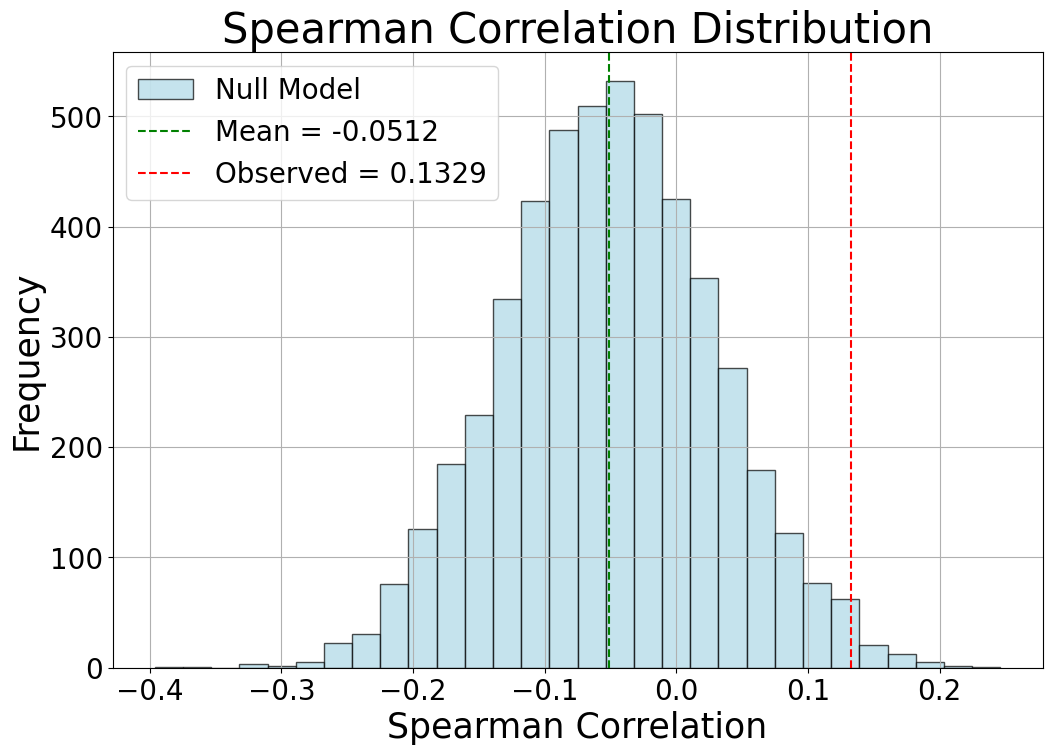

In [ ]:
plt.figure(figsize=(12, 8))
plt.hist(corr, bins=30, alpha=0.7, label="Null Model", color='lightblue', edgecolor='black')

print(f'Expected spearman correlation: {expected_corr}')
print(f'Mean spearman correlation: {np.mean(corr)}')
print(f'Standard deviation spearman correlation: {np.std(corr)}')
plt.xlabel('Spearman Correlation', size=25)
plt.ylabel('Frequency', size=25)
plt.title('Spearman Correlation Distribution', size=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.axvline(np.mean(corr), color='green', linestyle='--', label=f"Mean = {np.mean(corr):.4f}")
plt.axvline(expected_corr, color='red', linestyle='--', label=f"Observed = {expected_corr:.4f}")
plt.legend(fontsize=20)
plt.show()

In [ ]:
from scipy import stats
z_value = compute_z_value(corr, expected_corr)
print(f'z-value: {z_value}')

p_one_right = 1 - stats.norm.cdf(z_value)      # una coda destra
print(f'one-tailed right p-value: {p_one_right}')

z-value: 2.2858720693942636
one-tailed right p-value: 0.01113087194362894


# L2->L3

In [ ]:
print(f"Loading Layer 2 from: {LAYER2_GEXF}")
layer2 = nx.read_gexf(LAYER2_GEXF)
print(f"Loaded Layer 2: |V|={layer2.number_of_nodes()}, |E|={layer2.number_of_edges()}")

Loading Layer 2 from: /Users/HP/Desktop/layer2.gexf
Loaded Layer 1: |V|=1084, |E|=54210


In [46]:
print(f"Loading Layer 3 from: {LAYER3_GEXF}")
layer3 = nx.read_gexf(LAYER3_GEXF)
print(f"Loaded Layer 3: |V|={layer3.number_of_nodes()}, |E|={layer3.number_of_edges()}")

Loading Layer 3 from: /Users/HP/Desktop/layer3.gexf
Loaded Layer 3: |V|=799, |E|=1936


## Preserving degree

In [47]:
RESULTS = '/Users/HP/Desktop/UNI/LM_1/ACN/ACN_project/data/edge_overlap_L2_Null3.npy'
RESULTS_CORR = '/Users/HP/Desktop/UNI/LM_1/ACN/ACN_project/data/spearman_corr_L2_Null3.npy'

### Edge-overlap ratio

In [48]:
edge_overlap_ratios = np.load(RESULTS)
print(f"Loaded edge overlap ratios from {RESULTS}, shape: {edge_overlap_ratios.shape}")

Loaded edge overlap ratios from /Users/HP/Desktop/UNI/LM_1/ACN/ACN_project/data/edge_overlap_L2_Null3.npy, shape: (5000,)


In [49]:
E2 = _edge_set_undirected(layer2)
E3 = _edge_set_undirected(layer3)
expected_edge_overlap_ratio = len(E2 & E3) / min(len(E2), len(E3)) if min(len(E2), len(E3)) > 0 else 0.0

Expected edge overlap ratio: 0.27014462809917356
Mean edge overlap ratio: 0.10315764462809916
Standard deviation edge overlap ratio: 0.005380013783873077


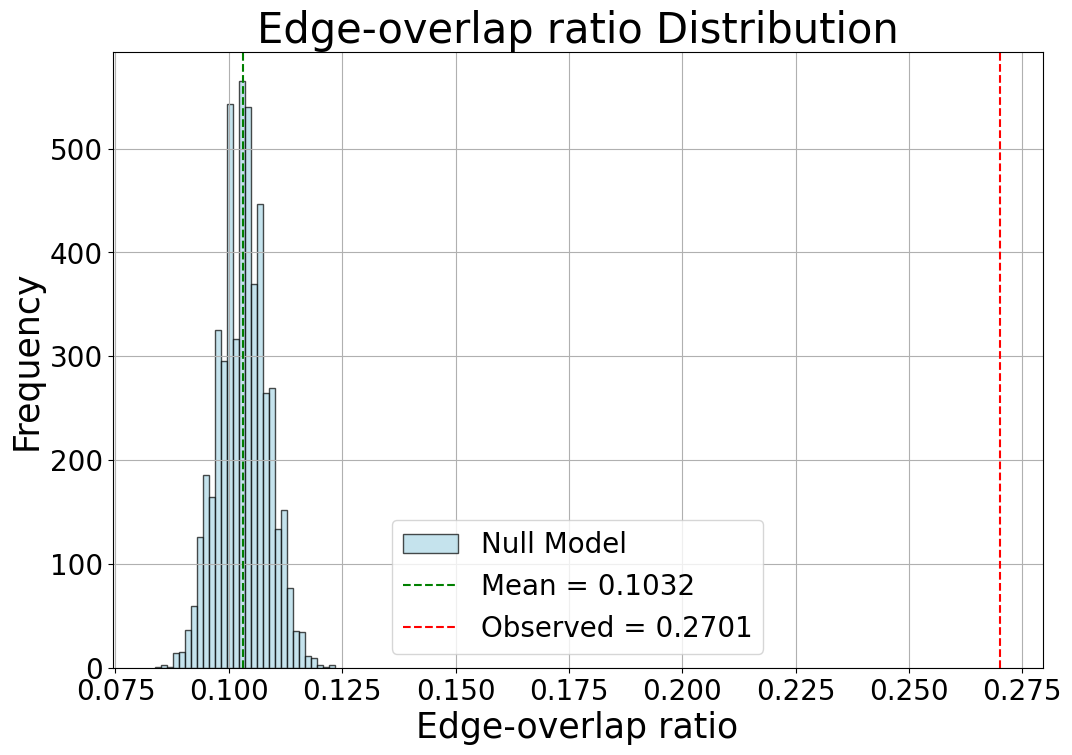

In [50]:
plt.figure(figsize=(12, 8))
plt.hist(edge_overlap_ratios, bins=30, alpha=0.7, label="Null Model", color='lightblue', edgecolor='black')

print(f'Expected edge overlap ratio: {expected_edge_overlap_ratio}')
print(f'Mean edge overlap ratio: {np.mean(edge_overlap_ratios)}')
print(f'Standard deviation edge overlap ratio: {np.std(edge_overlap_ratios)}')
plt.xlabel('Edge-overlap ratio', size=25)
plt.ylabel('Frequency', size=25)
plt.title('Edge-overlap ratio Distribution', size=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.axvline(np.mean(edge_overlap_ratios), color='green', linestyle='--', label=f"Mean = {np.mean(edge_overlap_ratios):.4f}")
plt.axvline(expected_edge_overlap_ratio, color='red', linestyle='--', label=f"Observed = {expected_edge_overlap_ratio:.4f}")
plt.legend(fontsize=20)
plt.show()

In [51]:
from scipy import stats
z_value = compute_z_value(edge_overlap_ratios, expected_edge_overlap_ratio)
print(f'z-value: {z_value}')

p_one_right = 1 - stats.norm.cdf(z_value)      # una coda destra
print(f'one-tailed right p-value: {p_one_right}')

z-value: 31.03528924743884
one-tailed right p-value: 0.0


### Spearman correlation

In [ ]:
corr = np.load(RESULTS_CORR)
print(f"Loaded correlations from {RESULTS_CORR}, shape: {corr.shape}")

Loaded correlations from /Users/HP/Desktop/UNI/LM_1/ACN/ACN_project/data/spearman_corr_L1_Null3.npy, shape: (5000,)


In [52]:
w2, w3 = _edge_weight_dict(layer2), _edge_weight_dict(layer3)
expected_corr = compute_corr(E2, E3, w2, w3)

Expected spearman correlation: 0.07742590445111203
Mean spearman correlation: -0.0511698591383184
Standard deviation spearman correlation: 0.08049728671980813


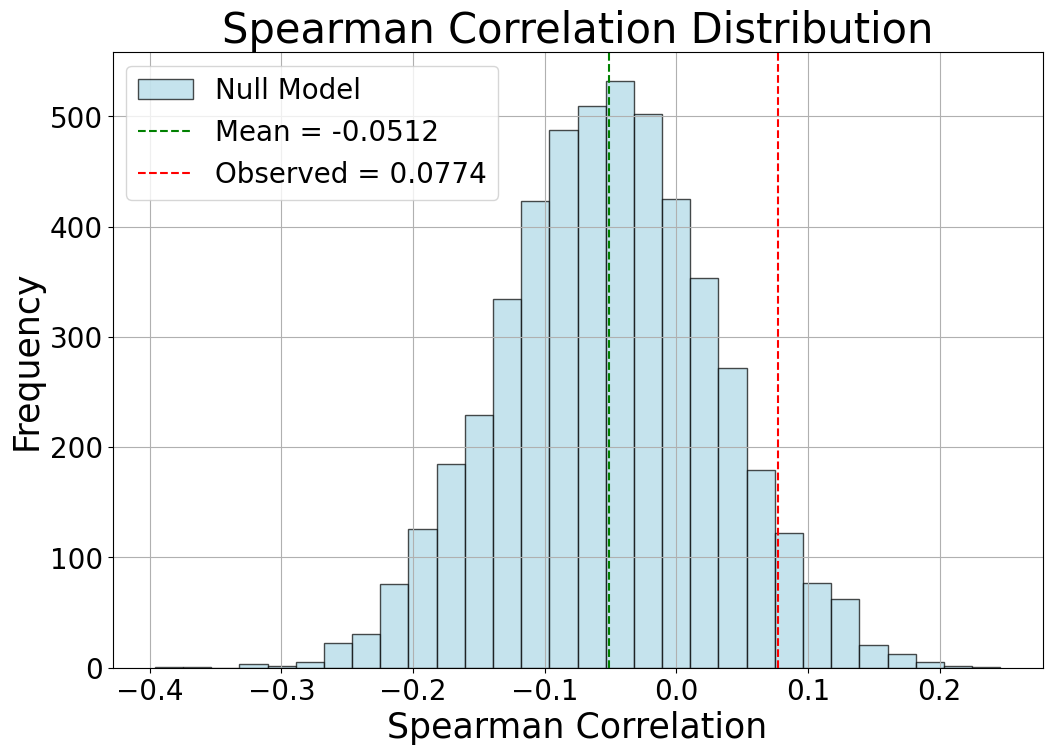

In [53]:
plt.figure(figsize=(12, 8))
plt.hist(corr, bins=30, alpha=0.7, label="Null Model", color='lightblue', edgecolor='black')

print(f'Expected spearman correlation: {expected_corr}')
print(f'Mean spearman correlation: {np.mean(corr)}')
print(f'Standard deviation spearman correlation: {np.std(corr)}')
plt.xlabel('Spearman Correlation', size=25)
plt.ylabel('Frequency', size=25)
plt.title('Spearman Correlation Distribution', size=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.axvline(np.mean(corr), color='green', linestyle='--', label=f"Mean = {np.mean(corr):.4f}")
plt.axvline(expected_corr, color='red', linestyle='--', label=f"Observed = {expected_corr:.4f}")
plt.legend(fontsize=20)
plt.show()

In [54]:
from scipy import stats
z_value = compute_z_value(corr, expected_corr)
print(f'z-value: {z_value}')

p_one_right = 1 - stats.norm.cdf(z_value)      # una coda destra
print(f'one-tailed right p-value: {p_one_right}')

z-value: 1.5973569869205004
one-tailed right p-value: 0.05509307732030422


## Preserving degree and weight sum

In [55]:
RESULTS = '/Users/HP/Desktop/UNI/LM_1/ACN/ACN_project/data/edge_overlap_L2_Null3_weights.npy'
RESULTS_CORR = '/Users/HP/Desktop/UNI/LM_1/ACN/ACN_project/data/spearman_corr_L2_Null3_weights.npy'

### Edge-overlap ratio

In [56]:
edge_overlap_ratios = np.load(RESULTS)
print(f"Loaded edge overlap ratios from {RESULTS}, shape: {edge_overlap_ratios.shape}")

Loaded edge overlap ratios from /Users/HP/Desktop/UNI/LM_1/ACN/ACN_project/data/edge_overlap_L2_Null3_weights.npy, shape: (5000,)


In [57]:
E2 = _edge_set_undirected(layer2)
E3 = _edge_set_undirected(layer3)
expected_edge_overlap_ratio = len(E2 & E3) / min(len(E2), len(E3)) if min(len(E2), len(E3)) > 0 else 0.0

Expected edge overlap ratio: 0.27014462809917356
Mean edge overlap ratio: 0.10318078512396694
Standard deviation edge overlap ratio: 0.005477034526464519


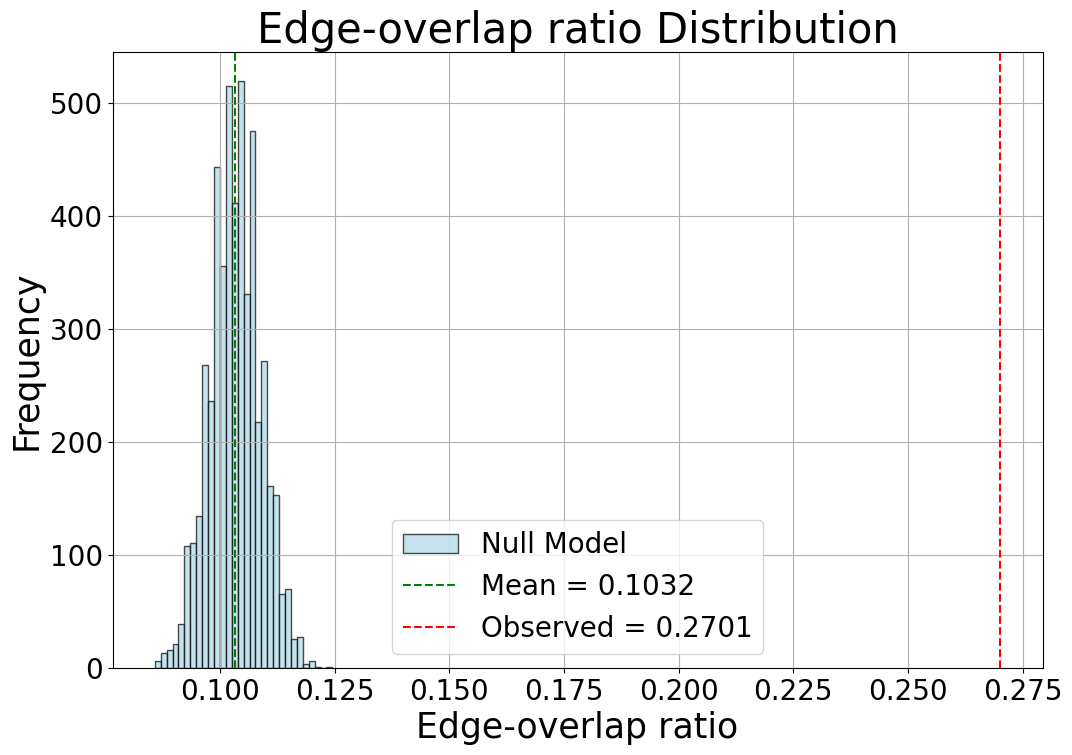

In [58]:
plt.figure(figsize=(12, 8))
plt.hist(edge_overlap_ratios, bins=30, alpha=0.7, label="Null Model", color='lightblue', edgecolor='black')

print(f'Expected edge overlap ratio: {expected_edge_overlap_ratio}')
print(f'Mean edge overlap ratio: {np.mean(edge_overlap_ratios)}')
print(f'Standard deviation edge overlap ratio: {np.std(edge_overlap_ratios)}')
plt.xlabel('Edge-overlap ratio', size=25)
plt.ylabel('Frequency', size=25)
plt.title('Edge-overlap ratio Distribution', size=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.axvline(np.mean(edge_overlap_ratios), color='green', linestyle='--', label=f"Mean = {np.mean(edge_overlap_ratios):.4f}")
plt.axvline(expected_edge_overlap_ratio, color='red', linestyle='--', label=f"Observed = {expected_edge_overlap_ratio:.4f}")
plt.legend(fontsize=20)
plt.show()

In [59]:
from scipy import stats
z_value = compute_z_value(edge_overlap_ratios, expected_edge_overlap_ratio)
print(f'z-value: {z_value}')

p_one_right = 1 - stats.norm.cdf(z_value)      # una coda destra
print(f'one-tailed right p-value: {p_one_right}')

z-value: 30.481302418185123
one-tailed right p-value: 0.0


### Spearman correlation

In [60]:
corr = np.load(RESULTS_CORR)
print(f"Loaded correlations from {RESULTS_CORR}, shape: {corr.shape}")

Loaded correlations from /Users/HP/Desktop/UNI/LM_1/ACN/ACN_project/data/spearman_corr_L2_Null3_weights.npy, shape: (5000,)


In [61]:
w2, w3 = _edge_weight_dict(layer2), _edge_weight_dict(layer3)
expected_corr = compute_corr(E2, E3, w2, w3)

Expected spearman correlation: 0.07742590445111203
Mean spearman correlation: 0.026914887246778124
Standard deviation spearman correlation: 0.06944092535211407


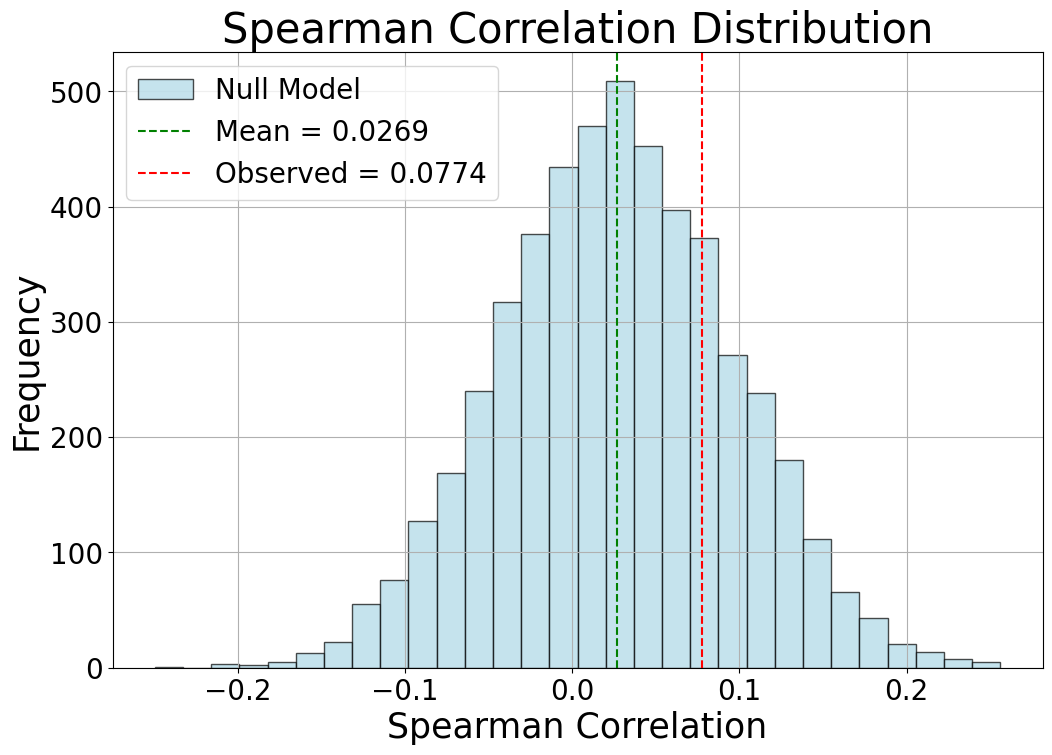

In [62]:
plt.figure(figsize=(12, 8))
plt.hist(corr, bins=30, alpha=0.7, label="Null Model", color='lightblue', edgecolor='black')

print(f'Expected spearman correlation: {expected_corr}')
print(f'Mean spearman correlation: {np.mean(corr)}')
print(f'Standard deviation spearman correlation: {np.std(corr)}')
plt.xlabel('Spearman Correlation', size=25)
plt.ylabel('Frequency', size=25)
plt.title('Spearman Correlation Distribution', size=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.axvline(np.mean(corr), color='green', linestyle='--', label=f"Mean = {np.mean(corr):.4f}")
plt.axvline(expected_corr, color='red', linestyle='--', label=f"Observed = {expected_corr:.4f}")
plt.legend(fontsize=20)
plt.show()

In [63]:
from scipy import stats
z_value = compute_z_value(corr, expected_corr)
print(f'z-value: {z_value}')

p_one_right = 1 - stats.norm.cdf(z_value)      # una coda destra
print(f'one-tailed right p-value: {p_one_right}')

z-value: 0.7273227652703724
one-tailed right p-value: 0.23351412773250457


## Preserving degree and clustering coefficient

In [64]:
RESULTS = '/Users/HP/Desktop/UNI/LM_1/ACN/ACN_project/data/edge_overlap_L2_Null3_clustering.npy'
#RESULTS_CORR = '/Users/HP/Desktop/UNI/LM_1/ACN/ACN_project/data/spearman_corr_L2_Null3_clustering.npy'

### Edge-overlap ratio

In [65]:
edge_overlap_ratios = np.load(RESULTS)
print(f"Loaded edge overlap ratios from {RESULTS}, shape: {edge_overlap_ratios.shape}")

Loaded edge overlap ratios from /Users/HP/Desktop/UNI/LM_1/ACN/ACN_project/data/edge_overlap_L2_Null3_clustering.npy, shape: (1500,)


In [66]:
E2 = _edge_set_undirected(layer2)
E3 = _edge_set_undirected(layer3)
expected_edge_overlap_ratio = len(E2 & E3) / min(len(E2), len(E3)) if min(len(E2), len(E3)) > 0 else 0.0

Expected edge overlap ratio: 0.27014462809917356
Mean edge overlap ratio: 0.1121797520661157
Standard deviation edge overlap ratio: 0.005751040264076273


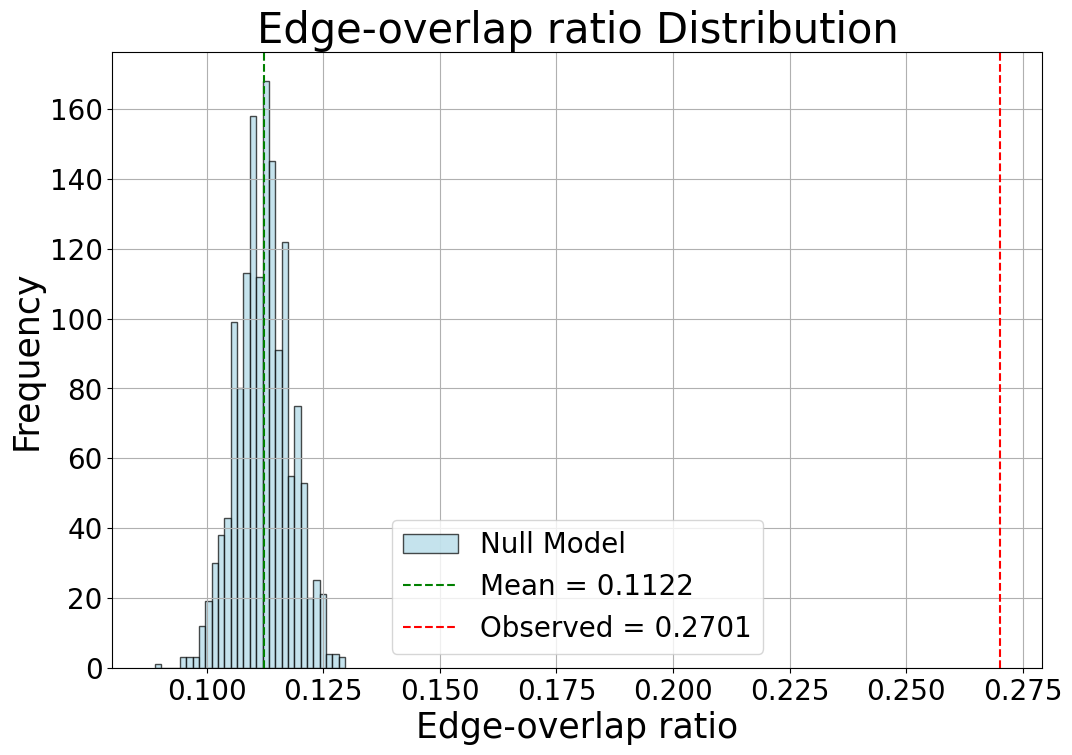

In [67]:
plt.figure(figsize=(12, 8))
plt.hist(edge_overlap_ratios, bins=30, alpha=0.7, label="Null Model", color='lightblue', edgecolor='black')

print(f'Expected edge overlap ratio: {expected_edge_overlap_ratio}')
print(f'Mean edge overlap ratio: {np.mean(edge_overlap_ratios)}')
print(f'Standard deviation edge overlap ratio: {np.std(edge_overlap_ratios)}')
plt.xlabel('Edge-overlap ratio', size=25)
plt.ylabel('Frequency', size=25)
plt.title('Edge-overlap ratio Distribution', size=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.axvline(np.mean(edge_overlap_ratios), color='green', linestyle='--', label=f"Mean = {np.mean(edge_overlap_ratios):.4f}")
plt.axvline(expected_edge_overlap_ratio, color='red', linestyle='--', label=f"Observed = {expected_edge_overlap_ratio:.4f}")
plt.legend(fontsize=20)
plt.show()

In [68]:
from scipy import stats
z_value = compute_z_value(edge_overlap_ratios, expected_edge_overlap_ratio)
print(f'z-value: {z_value}')

p_one_right = 1 - stats.norm.cdf(z_value)      # una coda destra
print(f'one-tailed right p-value: {p_one_right}')

z-value: 27.45802586047291
one-tailed right p-value: 0.0


### Spearman correlation

In [ ]:
corr = np.load(RESULTS_CORR)
print(f"Loaded correlations from {RESULTS_CORR}, shape: {corr.shape}")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/HP/Desktop/UNI/LM_1/ACN/ACN_project/data/spearman_corr_L1_Null3_clustering.npy'

In [ ]:
w2, w3 = _edge_weight_dict(layer2), _edge_weight_dict(layer3)
expected_corr = compute_corr(E2, E3, w2, w3)

Expected spearman correlation: 0.1328550436470079
Mean spearman correlation: -0.0511698591383184
Standard deviation spearman correlation: 0.08049728671980813


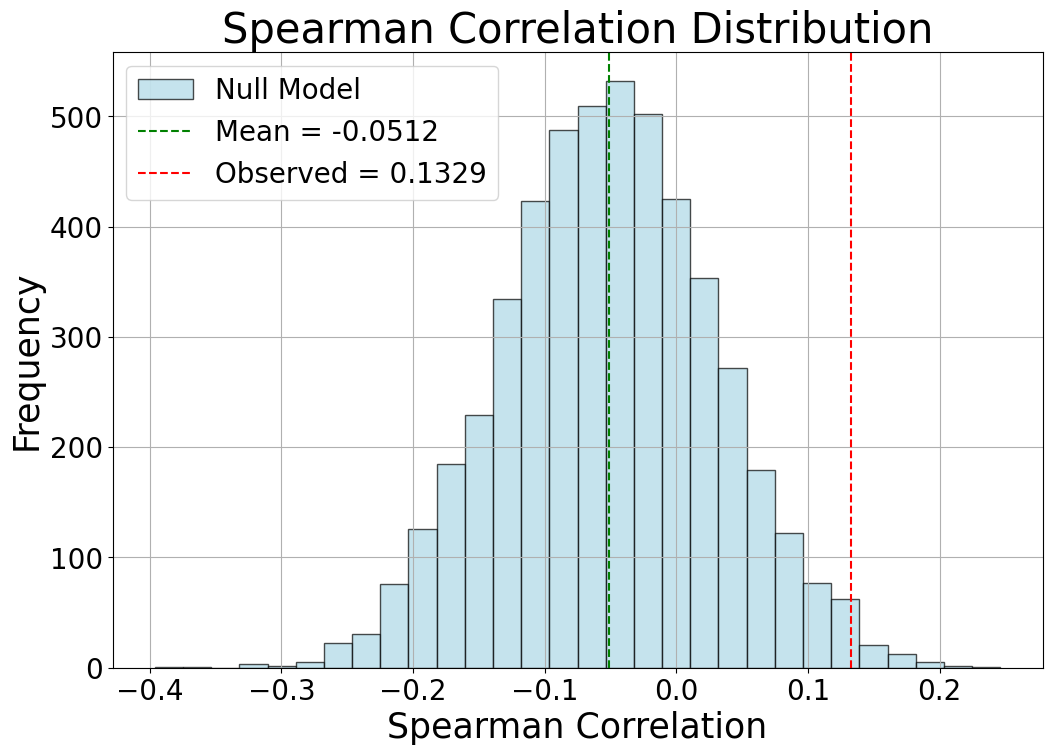

In [ ]:
plt.figure(figsize=(12, 8))
plt.hist(corr, bins=30, alpha=0.7, label="Null Model", color='lightblue', edgecolor='black')

print(f'Expected spearman correlation: {expected_corr}')
print(f'Mean spearman correlation: {np.mean(corr)}')
print(f'Standard deviation spearman correlation: {np.std(corr)}')
plt.xlabel('Spearman Correlation', size=25)
plt.ylabel('Frequency', size=25)
plt.title('Spearman Correlation Distribution', size=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.axvline(np.mean(corr), color='green', linestyle='--', label=f"Mean = {np.mean(corr):.4f}")
plt.axvline(expected_corr, color='red', linestyle='--', label=f"Observed = {expected_corr:.4f}")
plt.legend(fontsize=20)
plt.show()

In [ ]:
from scipy import stats
z_value = compute_z_value(corr, expected_corr)
print(f'z-value: {z_value}')

p_one_right = 1 - stats.norm.cdf(z_value)      # una coda destra
print(f'one-tailed right p-value: {p_one_right}')

z-value: 2.2858720693942636
one-tailed right p-value: 0.01113087194362894
